In [56]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

from ema_workbench import (ScalarOutcome, Policy)
from ema_workbench.analysis import prim

In [57]:
# Define problem formulation
from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(3)

INFO:dike_model_function:Model initialized


# Policy Robustness and Selection 
In this notebook the robustness of the policies found in the MORDM_Generating_alternatives file are analysed. According to the requirements of dike ring 4. 

Several metrics can be used to define the robustness, we will use the following two metrics to determine the policies for our actors: 

- Signal to Noise Ratio(SNR) 
- Maximum Regret



The policies that are used in this file have different numbers in the MORDM_Generating_aternatives file. The policies are defined as followed:

| MORDM_Alternatives file | Current file |
|-------------------------|--------------|
| 15                      | 0            |
| 64                      | 1            |
| 170                     | 2            |
| 1881                    | 3            |




## Importing and processing the required files
The files generated by the MORDM_scen_discovery.py file

In [58]:
#Import CSV results 
uncertainty_outcomes = pd.read_csv('data/Output/MOEA_test_outcomes.csv')
uncertainty_experiments = pd.read_csv('data/Output/MOEA_test_experiments.csv')

In [59]:
#append the metric Total Damage Other Dike Rings to see if our policies have a change of getting support from other dike rings
uncertainty_outcomes['Total Damage Other Dike Rings'] = uncertainty_outcomes['A.1_Expected Annual Damage']+uncertainty_outcomes['A.2_Expected Annual Damage']+uncertainty_outcomes['A.3_Expected Annual Damage']+uncertainty_outcomes['A.5_Expected Annual Damage']

In [60]:
#Append the metric Total Dike Investment Costs to see whether our policies have a chance of getting support from the bigger government actors
uncertainty_outcomes['Total Dike Investment Costs'] = uncertainty_outcomes['A.1_Dike Investment Costs']+uncertainty_outcomes['A.2_Dike Investment Costs']+uncertainty_outcomes['A.3_Dike Investment Costs']+ uncertainty_outcomes['A.4_Dike Investment Costs'] +uncertainty_outcomes['A.5_Dike Investment Costs']

# Signal to Noise ratio 
The SNR is a measure used to compare the level of a desired signal to the level of background noise. It is calculated as the ratio of the mean of the signal to the standard deviation of the noise. This section will first define the formula that will be used to calculate the SNR and calculate it for each of the policies, After that the results will be implemented

## Define SNR calculation

In [61]:
#relevant columns for our research
relevant_columns = [
    'A.4_Expected Annual Damage', 
    'A.4_Dike Investment Costs', 
    'A.4_Expected Number of Deaths', 
    'RfR Total Costs', 
    'Expected Evacuation Costs',
    'Total Damage Other Dike Rings', 
    'Total Dike Investment Costs'
]

In [62]:
def calc_signal_to_noise(values, optimization_goal):
    avg = np.mean(values)
    stdev = np.std(values)
    
    # Calculate SNR based on the optimization goal ('MAXIMIZE' or 'MINIMIZE')
    if optimization_goal == 'MAXIMIZE':
        return avg / stdev
    else:
        return avg * stdev

# Dictionary to store SNR scores for each policy
snr_scores = {}

# Iterate through each unique policy
for policy_name in np.unique(uncertainty_experiments['policy']):
    policy_scores = {}
    policy_filter = uncertainty_experiments['policy'] == policy_name

    # Calculate SNR for each relevant column
    for col in relevant_columns:
        data_values = uncertainty_outcomes[col][policy_filter]
        opt_goal = 'MINIMIZE'  # we want to minimize al the outcomes 
        snr_value = calc_signal_to_noise(data_values, opt_goal)
        policy_scores[col] = snr_value

    # Store the SNR scores for the current policy
    snr_scores[policy_name] = policy_scores

# Convert the SNR scores dictionary to a DataFrame
snr_df = pd.DataFrame.from_dict(snr_scores, orient='index')
snr_df


,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Total Damage Other Dike Rings,Total Dike Investment Costs
0,79.231909,9.685886e-14,75.651610,0.0,2.839947,2.832369,1.544155e-13
1,86.666724,8.081545e-14,80.169517,0.0,8.134500,8.344382,2.288289e-13
2,78.431922,1.940619e-13,75.844605,0.0,4.312820,4.403638,8.883419e-14
3,93.936327,1.019632e-13,92.191832,0.0,2.954076,2.978771,2.093793e-14


## Important result: 
Since the algorithm is set to minimise the signal to noise ratio the standard formula for calculating SNR is inverted. This gives the following result. 

- The RfR (Room for the River) score is 0 this means that there is 0 noise, this makes sense since the RfR total costs is a direct influence of policy levers. 
- The Signal-to-Noise Ratio (SNR) for dike investment costs is extremely low. This is because these costs are also direct responses to policy interventions. Therefore, their influence on the outcomes is very clear and pronounced.
- The Expected Annual Damage in Dike Ring 4 has a very high SNR. This means that the selected policies peform well in decreasing the expected annual damage. 
- The score for total damage in other dike rings is still high but it is much lower than when looking solely at dike ring 4. This makes sense because it is harder to minimize damage in all dike rings than in one specific dike ring

since the Rfr costs and dike investment costs are irrelevant when it comes to robusteness removing them from the plots leads to more insight


In [71]:
#relevant columns for our research
relevant_columns = [
    'A.4_Expected Annual Damage', 
    'A.4_Expected Number of Deaths'
    ,'Total Damage Other Dike Rings',
]
# Set to csv in order to put in appendix of report
snr_df.to_csv('data/output/signal_to_noise.csv')

<Figure size 1400x1000 with 0 Axes>

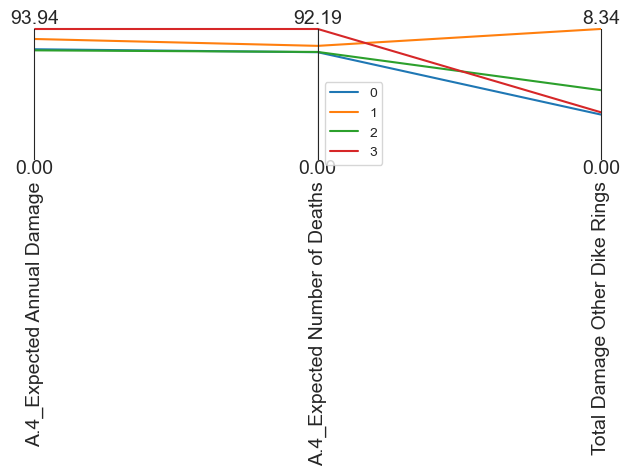

In [72]:
# Select relevant scores from the DataFrame
relevant_scores = snr_df[relevant_columns]

# Rename the DataFrame for clarity
score_data = relevant_scores

# Determine the limits for visualization
data_limits = parcoords.get_limits(score_data)
data_limits.loc[0, relevant_columns] = 0

# Plot the data using a parallel coordinates graph with a balanced figure size
plt.figure(figsize=(14, 10))
parallel_axes = parcoords.ParallelAxes(data_limits)
parallel_axes.plot(score_data)

# Adding a legend and displaying the plot
plt.legend(score_data.index)
plt.show()


Based on the Signal to Noise Ratio (SNR) analysis, Policy 0 is the least robust, as it is dominated by Policy 2. Policy 1 demonstrates strong performance across all dike rings. When specifically focusing on Dike Ring 4, Policy 3 emerges as the best performer.

## Maximum regret 
Another approach to test robustness is by using maximum regret. In this analysis, the regret for each policy across different outcome variables is calculated and scaled. The scaling ensures that every outcome variable has a policy with the maximum regret (scaled to 1) and a policy with the minimum regret (scaled to 0). This process helps in comparing the relative performance of policies across various outcome variables.

Steps to Calculate and Scale Maximum Regret:
- Evaluate Policies Across Scenarios:For each policy, evaluate the performance across all scenarios for each outcome variable.
- Identify Best Performance for Each Scenario: For each scenario and each outcome variable, identify the best possible performance across all policies.
- Calculate Regret for Each Policy: For each policy and each outcome variable, calculate the regret as the difference between the best performance and the current policy's performance in that scenario.
- Scale the Regret: Normalize the regret values for each outcome variable to a scale of 0 to 1, where 0 represents the policy with the least regret and 1 represents the policy with the most regret.

In [65]:
# Initialize dictionaries to store overall and maximum regrets
total_regret = {}
highest_regret = {}

for metric in uncertainty_outcomes[relevant_columns]:
    policies = uncertainty_experiments['policy']

    # Create a DataFrame with the necessary information
    combined_data = pd.DataFrame({
        metric: uncertainty_outcomes[metric],
        "policy": uncertainty_experiments['policy'],
        "scenario": uncertainty_experiments['scenario']
    })

    # Reshape the DataFrame by pivoting over policy and scenario
    reshaped_data = combined_data.pivot(index='scenario', columns='policy')

    # Flatten the resulting hierarchical index from pivoting
    reshaped_data.columns = reshaped_data.columns.get_level_values(1)

    # Calculate the regret for each data point in the DataFrame
    regret_values = (reshaped_data.max(axis=1).values[:, np.newaxis] - reshaped_data).abs()

    # Store the regret calculations in the dictionaries
    total_regret[metric] = regret_values
    highest_regret[metric] = regret_values.max()

# Display the results 
total_regret, highest_regret


({'A.4_Expected Annual Damage': policy      0    1    2    3
  scenario                    
  0         0.0  0.0  0.0  0.0
  1         0.0  0.0  0.0  0.0
  2         0.0  0.0  0.0  0.0
  3         0.0  0.0  0.0  0.0
  4         0.0  0.0  0.0  0.0
  ...       ...  ...  ...  ...
  9995      0.0  0.0  0.0  0.0
  9996      0.0  0.0  0.0  0.0
  9997      0.0  0.0  0.0  0.0
  9998      0.0  0.0  0.0  0.0
  9999      0.0  0.0  0.0  0.0
  
  [10000 rows x 4 columns],
  'A.4_Dike Investment Costs': policy               0    1             2             3
  scenario                                               
  0         5.207899e+07  0.0  4.439819e+07  3.446627e+07
  1         5.207899e+07  0.0  4.439819e+07  3.446627e+07
  2         5.207899e+07  0.0  4.439819e+07  3.446627e+07
  3         5.207899e+07  0.0  4.439819e+07  3.446627e+07
  4         5.207899e+07  0.0  4.439819e+07  3.446627e+07
  ...                ...  ...           ...           ...
  9995      5.207899e+07  0.0  4.439819e+07

In [66]:
# Selecting the maximum regret values into a DataFrame
highest_regret_df = pd.DataFrame(highest_regret)
#total_regret_df = pd.DataFrame(total_regret)
# Selecting the maximum regret values for specific columns into a new DataFrame
selected_max_regret = highest_regret_df[['A.4_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Dike Investment Costs']]

# Set to csv in order to put in appendix of report
highest_regret_df.to_csv('data/output/max_regret.csv')

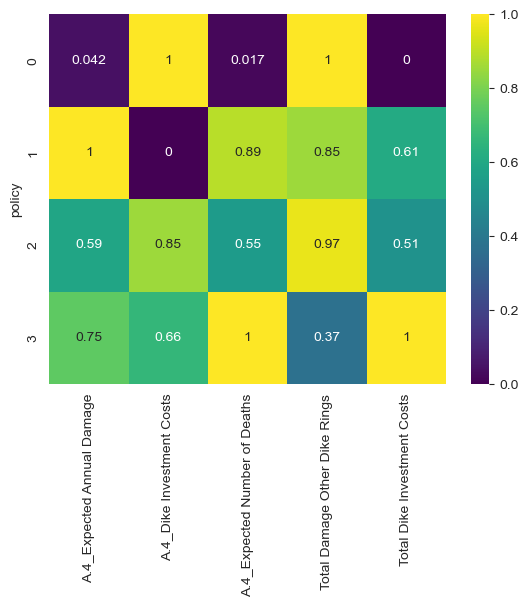

In [67]:
# Plot a heatmap of the normalized maximum regret values
sns.heatmap(highest_regret_df / highest_regret_df.max(), cmap='viridis', annot=True)
# Display the heatmap
plt.show()

the regret matrix reveals that each policy incurs different regret scores across the five evaluated outcomes. Key observations from this analysis include:

Absence of Dominated Policies: When considering all five outcomes, no policy is outright dominated by another. This suggests that each policy has some strengths and weaknesses relative to the others, depending on the specific outcome being considered.

Relevance of Budgetary Constraints: While budgetary considerations are included in the regret analysis, they are not a primary concern for our decision-maker. This perspective aligns with the argument that the regret associated with financial savings is considerably less significant than the regret linked to preventable deaths or damages. Thus, the financial aspect holds less weight in our overall evaluation.

Given this context, it is logical to refine our analysis by excluding the budgetary factors. By focusing solely on the outcomes related to deaths and damages, we can determine if any policies become dominated. This refined approach prioritizes the factors that have the greatest impact on the decision-making process.

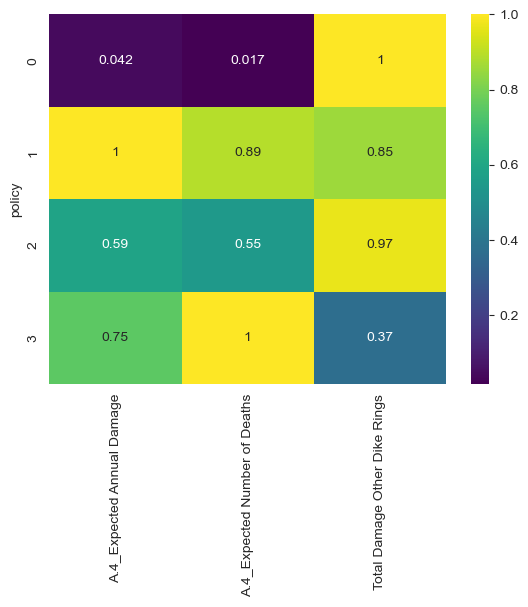

In [68]:
# Select specific columns for the heatmap
selected_columns = ['A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 'Total Damage Other Dike Rings']

# Plot a heatmap of the normalized maximum regret values for the selected columns
sns.heatmap(highest_regret_df[selected_columns] / highest_regret_df[selected_columns].max(), cmap='viridis', annot=True)

# Display the heatmap
plt.show()

# Conclusion maximum regret
When looking at the simplified matrix the following insights arise: 

- Policy 0 for Dike Ring 4: When evaluating the outcomes specifically for Dike Ring 4, Policy 0 emerges as the best policy by a significant margin. However, this optimal outcome for Dike Ring 4 comes with substantial trade-offs, as it implies that other areas will experience severe flooding and incur the most damage. This presents a significant risk for policymakers, as it concentrates the benefits in one area while exposing others to heightened vulnerability.


- Even though policy 1 is not dominated by other policies it is still the worst outcome in terms of regret when looking at the relative scores. For dike ring 4 it has the most regret, for all the other policies it has almost the highest regret. This makes, when looking solely at regret policy 1 is  

- High Regret in Policy 3: Policy 3 is associated with very high regret for Dike Ring 4, making it an undesirable option from the perspective of our specific dike ring. Nevertheless, Policy 3 is likely to be favorable for other dike rings, suggesting a high probability of its selection due to the collective benefits perceived by other regions. This scenario poses a challenge, as it highlights a potential conflict of interest between Dike Ring 4 and other areas.

- Comparison Between Policy 2 and Policy 0: Policy 2 results in substantially higher regret for Dike Ring 4 compared to Policy 0, with only marginally lower regret scores for the other dike rings. This indicates that, for our dike ring, Policy 0 is a far superior choice compared to Policy 2. The prioritization of Policy 0 would, therefore, align more closely with the best interests of Dike Ring 4, despite the potential negative implications for other areas.

